# Jena weather forecasting with PyTorch
EE 4940 class: Please make a copy in your Colab folder and run.

Ref: François Chollet "Python Deep Learning" 2nd ed, Ch10.

**Goal:** Forecast temperature 24 hours ahead using deep learning (DNN, Conv1D, LSTM, GRU).  
**Dataset:** Jena, Germany, weather station dataset (2009–2016), ~420,000 rows.  
**Features:** 14 (temperature, pressure, humidity, etc.).  
**Sampling rate:** Every 10 minutes.

We'll go through:
- Data loading and parsing
- Fourier analysis
- Sequence prep
- Multiple deep learning architectures (DNN, 1D CNN, LSTM, GRU)
- Forecast visualization and error analysis

In [ ]:
!wget -q https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip -o jena_climate_2009_2016.csv.zip

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# (Optional) fix seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

print("Setup complete. Jena data downloaded and unzipped.")


Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  
Setup complete. Jena data downloaded and unzipped.


Data Format: 14 features (Temperature, Pressure, Humidity, etc.), every 10 min.
Full Plot: ~7 years, see daily & seasonal cycles.

Short Slice: 10 days → day/night pattern stands out.

How many data points per day are we dealing with?

Below, why do we skip the first column?
The first column contains timestamps (e.g., "01.01.2009 00:10").
For modeling, we only use the numeric sensor data, not the timestamp itself.
So we slice with [1:] to skip the first column.


### Let's parse the CSV file output

| Column Index | CSV Header       | Description                     | Keep for modeling? |
|--------------|------------------|----------------------------------|---------------------|
| 0            | `Date Time`       | Timestamp of measurement         |  Skip             |
| 1            | `p (mbar)`        | Atmospheric pressure             |  Optional         |
| 2            | `T (degC)`        | Temperature in °C (label)        |   (Target)     |
| 3            | `Tpot (K)`        | Potential temperature in Kelvin  |  Optional         |
| 4            | `Tdew (degC)`     | Dew point temperature in °C      |  Optional         |
| ...          | ...               | More weather sensor readings     |  Optional         |

Only numeric columns starting from index 1 are parsed for training. We use `[1:]` to drop the `"Date Time"` column which is at index 0.


Header columns: ['"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Number of lines in dataset: 420451
raw_data shape: (420451, 14) | Temperature shape: (420451,)


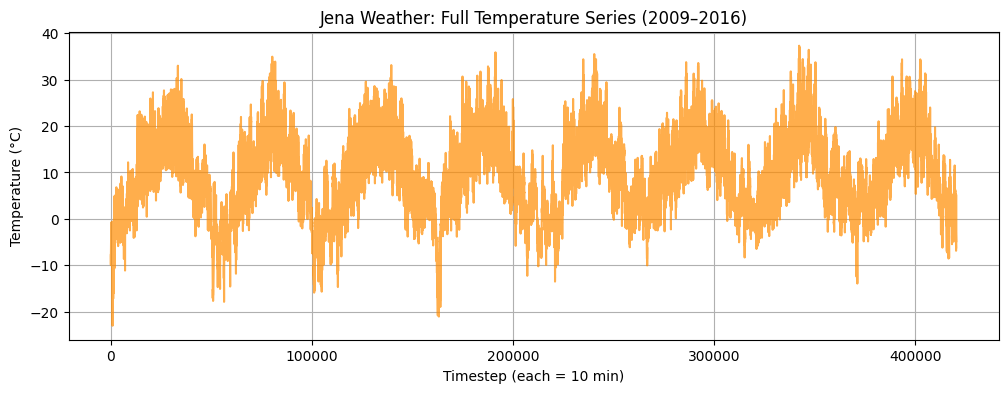

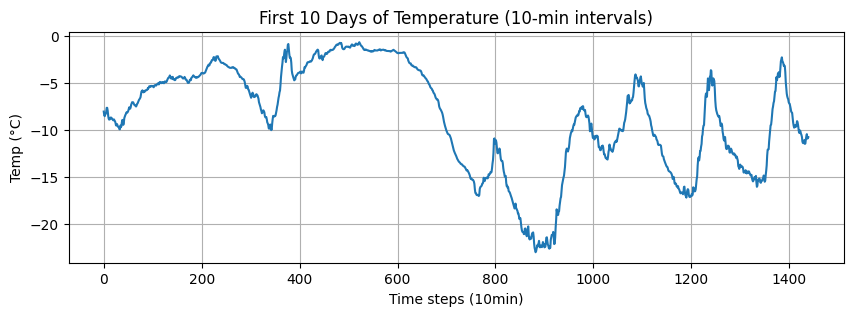

In [ ]:
data_path = "jena_climate_2009_2016.csv"

with open(data_path, 'r') as f:
    lines = f.read().splitlines()

# CSV files contain:
# Date Time, p (mbar), T (degC), Tpot (K), Tdew (degC),...
# 01.01.2009 00:10, 996.52, -8.02, 265.40, -8.90,...
# Take all columns except the first one (the timestamp column).

header = lines[0].split(",")[1:]  # skip the "Date Time" column
lines = lines[1:]

#above, what does [1:] do? It slices the list starting from the second element (index 1), removing the first one (index 0 = "Date Time"):

print("Header columns:", header)
print("Number of lines in dataset:", len(lines))

# Raw CSV files are just text (strings).
# To perform any computation or model training, we need to convert to float

raw_data = np.array([[float(x) for x in l.split(",")[1:]] for l in lines])
temperature = raw_data[:, 1]  # 2nd column => T(degC)
print("raw_data shape:", raw_data.shape, "| Temperature shape:", temperature.shape)

# Full series plot
plt.figure(figsize=(12,4))
plt.plot(temperature, alpha=0.7, color='darkorange')
plt.title("Jena Weather: Full Temperature Series (2009–2016)")
plt.xlabel("Timestep (each = 10 min)")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

# First 10 days (1440 points => 10 days * 24h * 6 points/hr)
plt.figure(figsize=(10,3))
plt.plot(temperature[:1440], '-')
plt.title("First 10 Days of Temperature (10-min intervals)")
plt.xlabel("Time steps (10min)")
plt.ylabel("Temp (°C)")
plt.grid(True)
plt.show()


FFT reveals dominant frequencies in the temperature series.
Daily peak near 1 day, possibly a 7-day or 365-day (yearly) cycle if data is large enough.
Log-scale helps display wide range of periods.

Q: Why do we see a large peak around 1 day in the log scale?

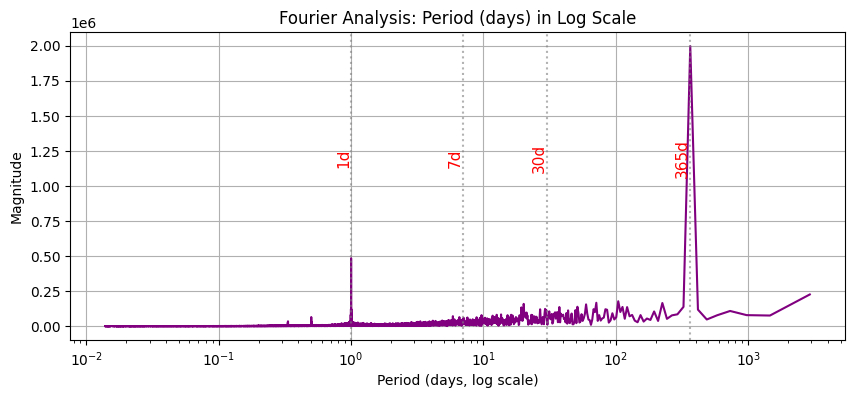

In [ ]:
import numpy as np
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# Suppose 'temperature' is your 1D array of temperature measurements
N = len(temperature)
T = 10.0/60.0  # 10 minutes => 1/6 hour between samples

# 1) Compute FFT
yf = fft(temperature - np.mean(temperature))
fft_magnitude = np.abs(yf[:N//2])   # Only keep positive frequencies
xf = fftfreq(N, d=T)[:N//2]         # Frequencies in "cycles per hour" (since T is hours)

# 2) Skip the zero frequency (DC term) to avoid division by zero
xf_nonzero = xf[1:]
fft_magnitude_nonzero = fft_magnitude[1:]

# 3) Convert freq in (cycles/hour) => period in (days)
#    freq (cycles/hour) => period in hours = 1/freq => period in days = (1/freq)/24
period_in_days = 1.0 / (xf_nonzero * 24.0)

# 4) Plot on a log scale for the period axis
plt.figure(figsize=(10,4))
plt.plot(period_in_days, fft_magnitude_nonzero, color='purple')
plt.xscale('log')
plt.title('Fourier Analysis: Period (days) in Log Scale')
plt.xlabel('Period (days, log scale)')
plt.ylabel('Magnitude')
plt.grid(True)
for d in [1, 7, 30, 365]:
    plt.axvline(x=d, color='gray', linestyle=':', alpha=0.6)
    plt.text(d, max(fft_magnitude_nonzero)*0.6, f'{int(d)}d', rotation=90,
             va='center', ha='right', fontsize=11, color='red')
plt.show()


To train a machine learning model, we divide our dataset into three parts:

| Split       | Portion | Purpose                                    |
|-------------|---------|--------------------------------------------|
| **Train**   | 50%     | Used to learn model weights                |
| **Val**     | 25%     | Used to tune hyperparameters, prevent overfitting |
| **Test**    | 25%     | Used only once at the end for final evaluation |

This matches the setup in **Chollet’s Deep Learning with Python**, (2nd ed. Chapter 10 Time series) and is common in time series modeling:
"[Chollet Ch10: In all our experiments, we’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to predict the future given the past, not the reverse, and your validation/test splits should reflect that. "


Normalization: individually scale each feature so mean=0, std=1 (based on training subset).
Avoids large feature differences (like pressure ~1000 vs. humidity ~ small range).

**Question: Why do we compute mean/std only on the train portion, not val or test?**



In [ ]:
N = len(raw_data)
num_train = int(N * 0.5)
num_val   = int(N * 0.25)
num_test  = N - (num_train + num_val)

mean = raw_data[:num_train].mean(axis=0)
std  = raw_data[:num_train].std(axis=0)

norm_data = (raw_data - mean) / std

print("Train size:", num_train, "Val size:", num_val, "Test size:", num_test)
print("Normalization complete.")


Train size: 210225 Val size: 105112 Test size: 105114
Normalization complete.


Equivalent to keras.utils.timeseries_dataset_from_array.
We slice out 5-day input windows (120 hours at 1 sample/hour) → target = 24 hours later.
stride=1 yields many overlapping samples.



## Understanding Time Series Windowing (create_timeseries)

### Time series 'windowing' creates input-target pairs

Here's the goal:

> Slice the full temperature time series into small overlapping windows  
> Each input = 5 days of hourly data → Predict the temperature **1 day later**



### Parameters Explained

| Parameter         | Meaning                                              |
|------------------|------------------------------------------------------|
| `sampling_rate`   | 6 = sample every 6 × 10min = 1 hour                  |
| `sequence_length` | 120 = 5 days × 24 hours                             |
| `delay`           | 24 = target is 24 hours after the input window ends |
| `stride`          | 1 = move forward by 1 time step each time           |



### Inputs and Targets

Each sample:
- `x`: shape (120, 14) → 5 days of hourly data, all 14 features
- `y`: scalar → the temperature (1 feature) 24 hours after the last input point

We build this manually (instead of using `keras.utils.timeseries_dataset_from_array`) to help understand what happens under the hood.



### Index Calculation Example

Assume the current window starts at `i = 1000`:

- Input:
  ```python
  x = data[1000 : 1000 + 120 * 6 : 6]


In [ ]:
sampling_rate    = 6      # Sample every 6 × 10min = 60min (1 sample per hour)
sequence_length  = 120    # Use past 120 hourly readings (5 days)
delay            = 24     # Predict 24 hours after the last input point
batch_size       = 256    # Size of mini-batches for training (used later)


def create_timeseries(data, targets, start_idx, end_idx,
                      sequence_length=120, delay=24,
                      sampling_rate=6, stride=1):
    """
    Equivalent to Keras timeseries_dataset_from_array.
    Generates overlapping (input, target) pairs from time series.

    Inputs:
      data         : normalized full dataset (shape: [time, features])
      targets      : 1D target array (e.g., temperature)
      start_idx    : index to begin slicing
      end_idx      : index to stop slicing
      sequence_length : # of timesteps to include in each input sequence
      delay        : how far ahead to predict the target
      sampling_rate: interval between input points (6 = every hour)
      stride       : how much to move forward each time (1 = full overlap)

    Output:
      x: [num_samples, sequence_length, num_features]
      y: [num_samples]
    """

    if end_idx is None:
        end_idx = len(data) - delay
    x_list, y_list = [], []
    # We subtract 'delay' in the max_idx, plus an extra 1 to avoid index errors
    max_idx = end_idx - sequence_length * sampling_rate - delay - 1
    i = start_idx
    while i <= max_idx:
        x = data[i : i + sequence_length*sampling_rate : sampling_rate]
        y = targets[i + sequence_length*sampling_rate + delay]
        x_list.append(x)
        y_list.append(y)
        i += stride
    return np.array(x_list), np.array(y_list)

# Boundaries for train, val, test
train_end = num_train
val_end   = num_train + num_val
test_end  = num_train + num_val + num_test

print("Train samples cover indices [0 ..", train_end, ")")
print("Val samples cover indices [", train_end, "..", val_end, ")")
print("Test samples cover indices [", val_end, "..", test_end, ")")

temp_targets = norm_data[:, 1]  # normalized temperature

x_train, y_train = create_timeseries(norm_data, temp_targets,
                                     0, train_end,
                                     sequence_length=sequence_length,
                                     delay=delay,
                                     sampling_rate=sampling_rate)

x_val,   y_val   = create_timeseries(norm_data, temp_targets,
                                     train_end, val_end,
                                     sequence_length, delay, sampling_rate)

x_test,  y_test  = create_timeseries(norm_data, temp_targets,
                                     val_end, test_end,
                                     sequence_length, delay, sampling_rate)

print("Train shape:", x_train.shape, y_train.shape)
print("Val shape:",   x_val.shape,   y_val.shape)
print("Test shape:",  x_test.shape,  y_test.shape)


Train samples cover indices [0 .. 210225 )
Val samples cover indices [ 210225 .. 315337 )
Test samples cover indices [ 315337 .. 420451 )
Train shape: (209481, 120, 14) (209481,)
Val shape: (104368, 120, 14) (104368,)
Test shape: (104370, 120, 14) (104370,)


**Baseline: “Tomorrow = Today.” Achieves ~2.5°C error.**

From Chollet book

Before we train a fancy model like an LSTM or GRU, we should ask: Can we beat a really dumb model?

The simplest idea:  
> **Predict that tomorrow's temperature will be the same as today’s**  
> i.e., the last observed temperature in the input window = tomorrow’s forecast.


### Why use a baseline?

- DL models must do better than guessing.
- To understand whether the task is learnable. If a naive baseline gives very low error, well, it might not be worth modeling further.


### How the baseline works

We evaluate this "copy last value" approach on the **validation** and **test** sets.

- Each input window has shape `(120, 14)`
- We extract the last value of the temperature feature (index `1`) in the window
- That’s our prediction: `x_val[:, -1, 1]`
- Then we compare it with the ground-truth target: `y_val`

### MAE (Mean Absolute Error)

We use **MAE** in degrees Celsius:


### Denormalization

We trained on normalized data. But we want MAE in **real °C units**.

So we convert values back to Celsius using:

In [ ]:
def revert_to_original(value, mean, std, feature_idx=1):
    """
    Convert normalized 'value' to real Celsius
    using mean, std of temperature (feature_idx=1).
    """
    return value * std[feature_idx] + mean[feature_idx]

def mae(a, b):
    return np.mean(np.abs(a - b))

baseline_preds_val  = x_val[:,-1,1]  # the last known temperature in the sequence
baseline_true_val   = y_val
baseline_preds_test = x_test[:,-1,1]
baseline_true_test  = y_test

# Convert to °C
baseline_preds_val_c  = revert_to_original(baseline_preds_val,  mean, std, 1)
baseline_true_val_c   = revert_to_original(baseline_true_val,   mean, std, 1)
baseline_preds_test_c = revert_to_original(baseline_preds_test, mean, std, 1)
baseline_true_test_c  = revert_to_original(baseline_true_test,  mean, std, 1)

val_mae_baseline  = mae(baseline_preds_val_c,  baseline_true_val_c)
test_mae_baseline = mae(baseline_preds_test_c, baseline_true_test_c)

print(f"Common-sense baseline VAL MAE:  {val_mae_baseline:.2f} °C")
print(f"Common-sense baseline TEST MAE: {test_mae_baseline:.2f} °C")


Common-sense baseline VAL MAE:  2.64 °C
Common-sense baseline TEST MAE: 2.85 °C


We wrap arrays in TensorDataset, then feed to PyTorch’s DataLoader.
DataLoader batches and shuffles the data for training loops.
shuffle=True for training set only.

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert arrays to torch tensors
x_train_t  = torch.from_numpy(x_train).float()
y_train_t  = torch.from_numpy(y_train).float()
x_val_t    = torch.from_numpy(x_val).float()
y_val_t    = torch.from_numpy(y_val).float()
x_test_t   = torch.from_numpy(x_test).float()
y_test_t   = torch.from_numpy(y_test).float()

train_ds = TensorDataset(x_train_t, y_train_t)
val_ds   = TensorDataset(x_val_t,   y_val_t)
test_ds  = TensorDataset(x_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

print("DataLoaders ready. batch_size =", batch_size)


DataLoaders ready. batch_size = 256


2 dense layers, ReLU. Simple and fast, but it has no sense of time.
Flatten 5-day window into a single vector.

Chollet: Note the lack of an activation function
on the this Dense layer, which is typical for a regression problem. We use mean
squared error (MSE) as the loss, rather than MAE, because unlike MAE, it’s smooth
around zero, which is a useful property for gradient descent. We will monitor MAE by
adding it as a metric in compile().

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze()


Next, let's try 1D convolutional net.
Each Conv1d kernel = local pattern in the time dimension.
MaxPool1d halving the time steps, so might lose ordering info.
Suits data that’s translation-invariant, which might not hold for daily cyclical patterns at specific times of day.

**Q: Why might Conv1D fail if morning vs. evening data differs drastically?**

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.conv = nn.Sequential(
            # replicate: x = layers.Conv1D(8, 24, activation="relu")(inputs), MaxPool(2)
            nn.Conv1d(in_channels=in_features, out_channels=8, kernel_size=24), nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(8, 8, kernel_size=12), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # replicate global average pooling
        )
        self.fc = nn.Linear(8, 1)
    def forward(self, x):
        # (batch, seq, features)
        x = x.permute(0,2,1)  # => (batch, features, seq)
        x = self.conv(x)      # => (batch, 8, 1)
        x = x.squeeze(-1)     # => (batch, 8)
        return self.fc(x).squeeze()


nn.LSTM(...) processes sequentially, maintaining hidden & cell states.
We apply dropout on the final time-step output.

Q: Which gating structures does LSTM have that help mitigate vanishing gradients?
A: Input gate, forget gate, output gate, plus cell state carrying info forward.

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, in_features, hidden=32):
        super().__init__()
        self.lstm = nn.LSTM(in_features, hidden, batch_first=True)
        # We'll do an extra dropout after the last step
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        # x => (batch, seq, features)
        out, (h, c) = self.lstm(x)
        last_timestep = out[:, -1, :]
        last_timestep = self.dropout(last_timestep)
        return self.fc(last_timestep).squeeze()


GRU simpler than LSTM: merges input & forget gates into an update gate.
Often trains slightly faster, can perform similarly.

In [ ]:
class GRUNet(nn.Module):
    def __init__(self, in_features, hidden=32):
        super().__init__()
        self.gru = nn.GRU(in_features, hidden, batch_first=True, num_layers=1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out, h = self.gru(x)
        last_timestep = out[:, -1, :]
        last_timestep = self.dropout(last_timestep)
        return self.fc(last_timestep).squeeze()


Loss = MSE.
We also track MAE in normalized scale.
gradient clipping with clip_grad_norm_ to mitigate exploding gradients.

Q: Why do we track both MSE and MAE?
A: MSE is stable for optimization, but MAE is more interpretable in real scale (especially when unnormalized).

In [ ]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # We'll store MSE and MAE for each epoch
    hist = {
        "train_mse": [],
        "train_mae": [],
        "val_mse":   [],
        "val_mae":   []
    }

    for epoch in range(1, epochs+1):
        # ------ TRAIN ------
        model.train()
        running_mse, running_mae = 0.0, 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_mse += loss.item()
            # MAE in normalized scale
            mae_batch = torch.mean(torch.abs(preds - yb)).item()
            running_mae += mae_batch

        train_mse = running_mse / len(train_loader)
        train_mae = running_mae / len(train_loader)

        # ------ VALIDATION ------
        model.eval()
        val_mse_tot, val_mae_tot = 0.0, 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                vloss = criterion(preds, yb)
                val_mse_tot += vloss.item()
                val_mae_tot += torch.mean(torch.abs(preds - yb)).item()
        val_mse = val_mse_tot / len(val_loader)
        val_mae = val_mae_tot / len(val_loader)

        hist["train_mse"].append(train_mse)
        hist["train_mae"].append(train_mae)
        hist["val_mse"].append(val_mse)
        hist["val_mae"].append(val_mae)

        print(f"Epoch {epoch}/{epochs} | "
              f"Train MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f} | "
              f"Val MSE: {val_mse:.4f}, Val MAE: {val_mae:.4f}")
    return hist


Each model prints train & val MSE/MAE for 50 epochs.
Please beware, this takes a long time. Use T4 in colab and start with ~10 epoches only.
Then we see the learning curves – watch for overfitting or divergence.

Q: If val MSE stops improving but train MSE keeps dropping, what is happening?
A: Overfitting.

Real °C: We revert from normalized scale (more interpretable).
Forecast Plot: 200 points from 1 batch to see if predictions align with actual curve.


In [ ]:
in_features = x_train.shape[2]  # number of features
epochs = 50

models = {
    "Dense": DenseNet(in_features * sequence_length),
    "Conv1D": ConvNet(in_features),
    "LSTM":   LSTMNet(in_features),
    "GRU":    GRUNet(in_features)
}

histories = {}
for name, net in models.items():
    print(f"\nTraining {name} model ...")
    hist = train_model(net, train_loader, val_loader, epochs=epochs, lr=0.001)
    histories[name] = hist

def plot_train_val(hist, title="Model", metric="mse"):
    """
    hist: dictionary with train_mse, train_mae, val_mse, val_mae
    metric: 'mse' or 'mae'
    """
    train_vals = hist[f"train_{metric}"]
    val_vals   = hist[f"val_{metric}"]
    plt.figure(figsize=(6,4))
    plt.plot(train_vals, 'bo-', label=f"Train {metric.upper()}")
    plt.plot(val_vals,   'ro--', label=f"Val {metric.upper()}")
    plt.title(f"{title}: {metric.upper()} Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.legend()
    plt.show()

for name, hist in models.items():
    pass

for name, hist in histories.items():
    plot_train_val(hist, title=name, metric="mse")
    plot_train_val(hist, title=name, metric="mae")

def evaluate_mae(model, data_loader):
    model.eval()
    preds_list, actual_list = [], []
    with torch.no_grad():
        for xb, yb in data_loader:
            p = model(xb)
            preds_list.append(p.cpu().numpy())
            actual_list.append(yb.cpu().numpy())
    preds_all  = np.concatenate(preds_list)
    actual_all = np.concatenate(actual_list)
    # revert from normalized scale => real °C
    preds_c  = revert_to_original(preds_all, mean, std, 1)
    actual_c = revert_to_original(actual_all, mean, std, 1)
    return mae(preds_c, actual_c)

for name, net in models.items():
    val_mae_  = evaluate_mae(net, val_loader)
    test_mae_ = evaluate_mae(net, test_loader)
    print(f"{name}: Val MAE={val_mae_:.2f}°C, Test MAE={test_mae_:.2f}°C")

def forecast_plot(model, loader, title="Forecast sample", n=200):
    # We'll take first 'n' from the first validation batch
    model.eval()
    with torch.no_grad():
        xb, yb = next(iter(loader))
        xb, yb = xb[:n], yb[:n]
        preds = model(xb).cpu().numpy()
        actual = yb.cpu().numpy()

    # revert to real scale
    preds_c = revert_to_original(preds, mean, std, 1)
    actual_c= revert_to_original(actual, mean, std, 1)

    plt.figure(figsize=(10,4))
    plt.plot(actual_c, 'o-', label='Actual Temp', alpha=0.7)
    plt.plot(preds_c,  'x-', label='Predicted',   alpha=0.7)
    plt.title(title)
    plt.xlabel("Sample index")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
for name, net in models.items():
    forecast_plot(net, val_loader, f"{name} Validation Forecast (sample 200 pts)")

class DebugLSTM(nn.Module):
    def __init__(self, in_features, hidden=32):
        super().__init__()
        self.lstm = nn.LSTM(in_features, hidden, batch_first=True)
        self.fc   = nn.Linear(hidden, 1)
    def forward(self, x, return_seq=False):
        out, (h, c) = self.lstm(x)
        last_step = out[:, -1, :]
        pred = self.fc(last_step).squeeze()
        if return_seq:
            return pred, out.detach()  # entire sequence hidden states
        else:
            return pred

# Example usage:
debug_lstm = DebugLSTM(x_train.shape[2], hidden=32)
_ = train_model(debug_lstm, train_loader, val_loader, epochs=3)

def visualize_lstm_states(model, loader):
    model.eval()
    with torch.no_grad():
        xb, yb = next(iter(loader))
        pred, seq_out = model(xb[:1], return_seq=True)
    seq_out = seq_out.squeeze(0).cpu().numpy().T  # shape => (hidden, seq)
    plt.figure(figsize=(12,4))
    plt.imshow(seq_out, aspect='auto', cmap='RdBu')
    plt.colorbar(label="Activation Intensity")
    plt.title("LSTM Hidden States Over Time")
    plt.xlabel("Time steps in sequence")
    plt.ylabel("Hidden units")
    plt.grid(False)
    plt.show()

visualize_lstm_states(debug_lstm, val_loader)



Training Dense model ...
Epoch 1/50 | Train MSE: 0.2862, Train MAE: 0.2767 | Val MSE: 0.0567, Val MAE: 0.1856
Epoch 2/50 | Train MSE: 0.0558, Train MAE: 0.1825 | Val MSE: 0.0514, Val MAE: 0.1758
Epoch 3/50 | Train MSE: 0.0496, Train MAE: 0.1717 | Val MSE: 0.0539, Val MAE: 0.1805
Epoch 4/50 | Train MSE: 0.0458, Train MAE: 0.1648 | Val MSE: 0.0522, Val MAE: 0.1779
Epoch 5/50 | Train MSE: 0.0437, Train MAE: 0.1610 | Val MSE: 0.0476, Val MAE: 0.1701
Epoch 6/50 | Train MSE: 0.0420, Train MAE: 0.1578 | Val MSE: 0.0592, Val MAE: 0.1899
Epoch 7/50 | Train MSE: 0.0408, Train MAE: 0.1555 | Val MSE: 0.0551, Val MAE: 0.1827
Epoch 8/50 | Train MSE: 0.0395, Train MAE: 0.1532 | Val MSE: 0.0489, Val MAE: 0.1704
Epoch 9/50 | Train MSE: 0.0387, Train MAE: 0.1515 | Val MSE: 0.0490, Val MAE: 0.1718
Epoch 10/50 | Train MSE: 0.0380, Train MAE: 0.1503 | Val MSE: 0.0507, Val MAE: 0.1745
Epoch 11/50 | Train MSE: 0.0375, Train MAE: 0.1493 | Val MSE: 0.0497, Val MAE: 0.1753
Epoch 12/50 | Train MSE: 0.0369, Trai

KeyboardInterrupt: 

above plot (LSTM hidden states over time)
Heatmap: row = hidden unit, column = time step.
Some units may track day/night transitions, others long-range trends.

Q: Does a bright red row at certain timesteps mean the LSTM ‘knows’ it’s midday?

In [ ]:
class DebugLSTM(nn.Module):
    def __init__(self, input_dim, hidden=32):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, batch_first=True)
        self.fc   = nn.Linear(hidden, 1)

    def forward(self, x, return_hidden=False):
        # out => (batch, seq, hidden)
        out, (h, c) = self.lstm(x)
        last = out[:, -1, :]
        pred = self.fc(last).squeeze()
        if return_hidden:
            return pred, out  # returns entire hidden sequence
        else:
            return pred

def train_with_logging(model, train_loader, val_loader, epochs=5, lr=0.001):
    """
    After each epoch, we pick the SAME sample from train_loader
    and store its hidden states => hidden_states_by_epoch[epoch]
    for advanced visualization.
    """
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # We'll pick the first batch from train_loader to sample from
    sample_x, sample_y = next(iter(train_loader))
    sample_x = sample_x[:1]  # just one sample
    hidden_states_by_epoch = []  # store hidden states for each epoch

    for epoch in range(epochs):
        # --- Train loop ---
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Store hidden states for the sample
        model.eval()
        with torch.no_grad():
            _, seq_out = model(sample_x, return_hidden=True)
            hidden_states_by_epoch.append(seq_out.detach().cpu().numpy())

        # Evaluate on val set quickly
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                val_loss += criterion(model(xb), yb).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Val MSE: {val_loss:.4f}")

    return hidden_states_by_epoch

def visualize_hidden_states_across_epochs(hidden_states_by_epoch):
    """
    hidden_states_by_epoch is a list of arrays: each array => shape (1, seq, hidden)
    We'll create multiple subplots or an animation to show how
    the heatmap evolves each epoch for the same sample.
    """
    import math
    num_epochs = len(hidden_states_by_epoch)
    cols = 4
    rows = math.ceil(num_epochs / cols)

    plt.figure(figsize=(4*cols, 3.5*rows))

    for i, hs in enumerate(hidden_states_by_epoch):
        # hs shape => (1, seq, hidden)
        hs_2d = hs.squeeze(0).T  # => (hidden, seq)
        plt.subplot(rows, cols, i+1)
        plt.imshow(hs_2d, aspect='auto', cmap='RdBu')
        plt.title(f"Epoch {i+1}")
        plt.xlabel("Time steps")
        plt.ylabel("Hidden units")

    plt.tight_layout()
    plt.show()

# Example usage:
debug_lstm = DebugLSTM(x_train.shape[2], hidden=16)  # smaller hidden for demonstration
epochs = 10
logged_states = train_with_logging(debug_lstm, train_loader, val_loader, epochs=epochs)
visualize_hidden_states_across_epochs(logged_states)


**Sum**

Data loading & initial plots show raw temperature & cyclical patterns.
Fourier analysis: strong daily cycle.
Normalization & Timeseries slicing replicate Chollet’s approach.
Common-sense baseline => ~2.5°C MAE.
Dense & Conv1D often near or worse than baseline.
LSTM & GRU can beat the baseline, since they capture time series features.

Dense: flattens everything, ignoring sequence order.

Conv1D: good for translation-invariant patterns, but weather’s daily cycle is not quite translation-invariant, so it struggles.
How does a convolution’s assumption fail for daily patterns?
It assumes translation invariance, but morning vs. night is position-dependent.

LSTM/GRU: use gating to track cyclical/temporal signals, so often better than baseline.

Vanishing gradients: LSTM/GRU gating helps.

Vanishing gradient in RNN:
Simple math check: if each step’s gradient is multiplied by 0.9 for 120 steps, that’s
0.9^120≈0.00003,  nearly zero.

Implementation simplicity:
The LSTM and GRU code is short in PyTorch, but the concept (gating, states) is deeper than building a Dense layer.

Computational cost: RNNs run more slowly due to sequential time-step unrolling.

This is where the power of gating comes in. We’re letting backprop figure out daily vs. seasonal cycles, rather than hand-programming them. That’s the essence of deep learning: we set up the architecture (hypothesis space), and the data does the rest, end-to-end, in automated fashion.